# A single layer interpretable neural network to denoise a noisy signal

In this notebook we attempt to reproduce one of the main results from my PhD thesis wherein a single layer neural network is tasked with denoising a noisy signal. My thesis can be found [here](https://eprints.soton.ac.uk/493825/1/Deep_Learning_Applications_and_Interpretation_in_Signal_Processing_and_Magnetic_Resonance_no_sig_.pdf). Please cite any work used.
        
        Choudhury, Tajwar      (2024)     Deep learning applications and interpretation in signal processing and magnetic resonance.  University of Southampton, Doctoral Thesis, 171pp.    

In the thesis we use generated sine and cosine signals according to the following equation:

$f(t) = A_1 \sin(\omega_1 \pi t) + A_2 (\sin\omega_2 \pi t)$

then add Gaussian noise to each signal, producing a database of clean signals with their corresponding noisy counterparts.

After this we train a single layer neural network using a hyperbolic tangent activation function. The network is able to successfully remove the noise from the input noisy signals, which the headline result being the interpretation of the network. We find that it the weight matrix represents a sinc filter. Essentially what the network does is a convolution of this sinc filter over the input to average out the noise.

The code for this work was written in MATLAB. Here will attempt to reproduce the experiment using Python and visualise the result.

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
import torch
import torch.nn as nn
import torch.optim as optim
import random

In [ ]:
x = np.arange(0, 8, 0.2)
noise = np.random.normal(0,0.1, len(x))
y = random.uniform(0,3)*np.sin(random.uniform(0,3)*x)
y_noisy = y+noise

A generated sinusoidal signal with additive noie. The red signal represents the input to the network and the green signal is what we want from the output.

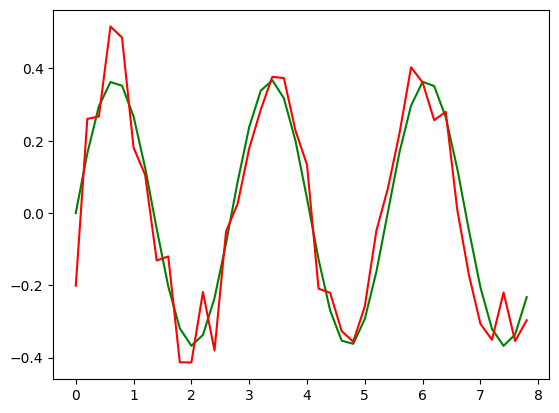

In [ ]:
plt.plot(x, y, color='green')
plt.plot(x, y_noisy, color='red')
plt.show()

We now generate a databse of signals with random parameters for the sine function to obtain a variety of signals to train on. In the original work we use 4 different parameters, $A_1, A_2, \omega_1, \omega_2$ with a signal length of 256 points. Here we will use 160 points.

$f(x) = A_1\sin(\alpha*x)$

where $A_1$ and $\alpha$ are randomly generated numbers between an arbitrary range of $[0,3]$, selected to introduce some variation but not too much. This will be explained later.

In [ ]:
# Generate database
num_instances = 10000
x = np.arange(0,32,0.2)
signal_length = len(x)

clean = np.zeros((num_instances, signal_length))
noisy = np.zeros((num_instances, signal_length))

for i in range(num_instances):
    noise = np.random.normal(0,0.1, len(x))
    y = random.uniform(0,1)*np.sin(random.uniform(0,2.5)*x)
    y_noisy = y+noise

    clean[i,:] = y
    noisy[i,:] = y_noisy

Now that we have a training database we can construct our single layer neural network. It is not overly important to generate testing and validation sets contrary to standard machine learning pracise as we already know what the network is meant to be doing to the input, for the time being we simply want to see if our network here produces a similar weight matrix to the one found in my thesis.

In [ ]:
# Reshape data for neural network
x_data = torch.tensor(noisy, dtype=torch.float32)
y_data = torch.tensor(clean, dtype=torch.float32)

Create a single layer neural network with no activation function. Essentially this is just a matrix with learned parameters (the entries in the matrix) which should transform $x$, the noisy input signal, into $y$, the clean signal.

The network represents the following equation:

$f(x) = W(x)$

In [ ]:
class net(torch.nn.Module):

    def __init__(self):
        super(net, self).__init__()
        # Single hidden layer with no bias
        self.fc = nn.Linear(signal_length,signal_length, bias = False)

    def forward(self,x):
      x = self.fc(x)
      #x = torch.sigmoid(x)
      return x

The number of parameters is the number of elements in an $n\times n$ matrix where $n$ is the dimension of the input.

In [ ]:
model = net()
criterion = nn.MSELoss()
optimizer = optim.Adam(model.parameters(), lr=0.01)

# Number of params
pytorch_total_params = sum(p.numel() for p in model.parameters() if p.requires_grad)
print(f'Number of parameters:{pytorch_total_params}')
print(signal_length)

Number of parameters:25600
160


In [ ]:
# Training loop
num_epochs = 1000
for epoch in range(num_epochs):
    # Forward pass
    outputs = model(x_data)
    loss = criterion(outputs, y_data)

    # Backward pass and optimization
    optimizer.zero_grad()
    loss.backward()
    optimizer.step()

    # Print loss
    if (epoch + 1) % 50 == 0:
        print(f'Epoch [{epoch+1}/{num_epochs}], Loss: {loss.item():.4f}')


Epoch [50/1000], Loss: 0.0031
Epoch [100/1000], Loss: 0.0020
Epoch [150/1000], Loss: 0.0018
Epoch [200/1000], Loss: 0.0017
Epoch [250/1000], Loss: 0.0017
Epoch [300/1000], Loss: 0.0016
Epoch [350/1000], Loss: 0.0016
Epoch [400/1000], Loss: 0.0016
Epoch [450/1000], Loss: 0.0016
Epoch [500/1000], Loss: 0.0016
Epoch [550/1000], Loss: 0.0016
Epoch [600/1000], Loss: 0.0016
Epoch [650/1000], Loss: 0.0016
Epoch [700/1000], Loss: 0.0016
Epoch [750/1000], Loss: 0.0016
Epoch [800/1000], Loss: 0.0016
Epoch [850/1000], Loss: 0.0016
Epoch [900/1000], Loss: 0.0016
Epoch [950/1000], Loss: 0.0016
Epoch [1000/1000], Loss: 0.0016


Extracting the weights from the network

Lets see how the network performs. We aren't necessarily interested in an accuracy score as we aren't doing a classification task; we want to see how well it removes the noise from the input signal. We can just select a random pair from the training database or if we really wanted to, generate a new one.

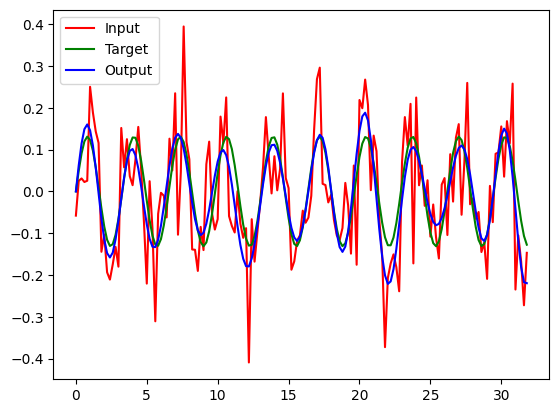

In [ ]:
# Select input (noisy signal), target (generated clean signal) and output (network output)
idx = 1
input = x_data[idx].unsqueeze(0)
target = y_data[idx].unsqueeze(0)
output = model(input)

# Convert tensors to np arrays
input = input.detach().numpy()
target = target.detach().numpy()
output = output.detach().numpy()

# Plotting
plt.figure()
plt.plot(x, input[0], color='red')
plt.plot(x, target[0], color='green')
plt.plot(x, output[0], color='blue')
plt.legend(['Input', 'Target', 'Output'])
plt.show()

We can see the network performs *okay*. The green line represents the original generated signal to which the noise is added, producing the input to the network, which is the red signal. The blue signal is the output of the network, showing removal of the noise but some loss of uniformity to the original signal. There is further investigation into varying parameter sizes for the initial sinusoidal equations and the effect this has on the network performance, in the thesis.




# Interpreting this network

First we need to extract the weights. As mentioned above, the network is carrying out the following transformation:

$f(x) = W(x)$

We have turned off bias vectors as they are not required for this task and likewise neither is an activation function. So in order to interpret what the network, we need to know what transformation this matrix $W$ is doing, in a meaningful way, aiming to quantify the transformation somehow.

In [ ]:
W = model.fc.weight.data
W = W.numpy()

Plotting the scaled colour image of the weight matrix - more or less exactly what is in the thesis!

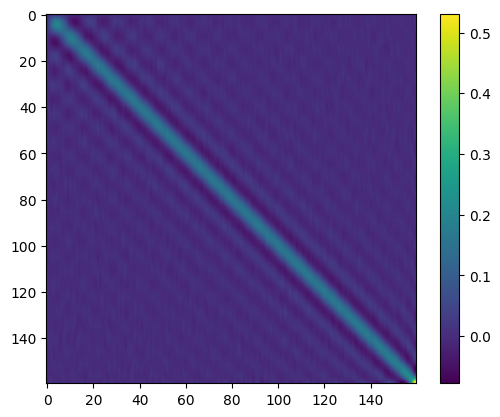

In [ ]:
plt.imshow(W)
plt.colorbar()
plt.show()


The transformation is equivalent to taking the convolution of the anti-diagonal of the weight matrix with the input. Plotting the anti-diagonal, we see a sinc function. This is the exact filter the network uses to denoise the input.

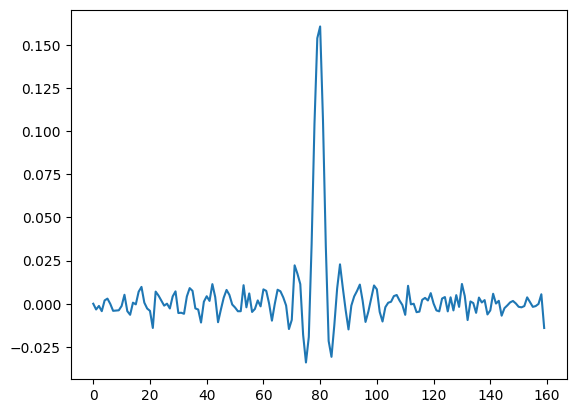

In [ ]:
# Plot diagonal of the weight matrix W
diag = np.fliplr(W).diagonal()
plt.plot(diag)
plt.show()

Now that we know the network evolves a sinc function which it uses to filter the input, we can attempt to fit a sinc function to the parameters of the sinc function found in the network. We can then create a "synthetic weight matrix", apply it to our input in the same way the network does, and if the output is the same, we can conclude the network is not a black box.

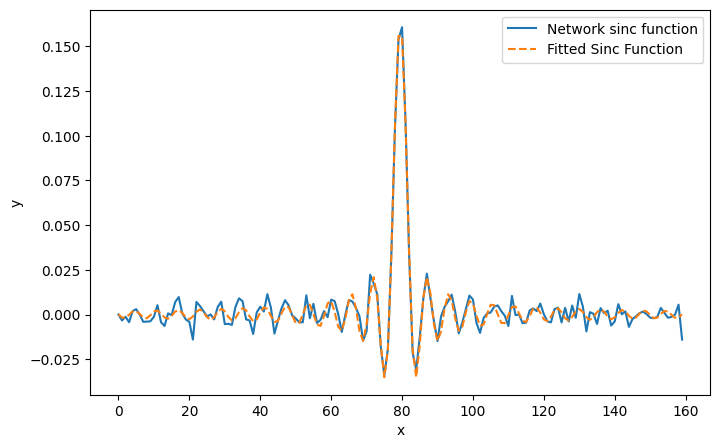

In [ ]:
from scipy.optimize import curve_fit

x = np.arange(160)
def sinc_model(x, A, B, C):
    return A * np.sinc(B * (x - C) + 1e-10)

# Find parameters
params, _ = curve_fit(sinc_model, x, diag, p0=[1, 0.1, 80])
A_fit, B_fit, C_fit = params

# Generate fitted data
fitted_data = sinc_model(x, A_fit, B_fit, C_fit)

# Plots
plt.figure(figsize=(8, 5))
plt.plot(x, diag, label="Network sinc function")
plt.plot(x, fitted_data, label="Fitted Sinc Function", linestyle="--")
plt.legend()
plt.xlabel("x")
plt.ylabel("y")
plt.show()

We can now stack this fitted sinc function such that it is the diagonal of a matrix, this is known as a Toeplitz matrix. The result is a "synthetic" matrix which resembles the weight matrix from the network, and will produce the same output.

We know have a DSP analogue with defined parameters (the sinc function and its fitted parameters) which characterises what the network is doing mathematically.

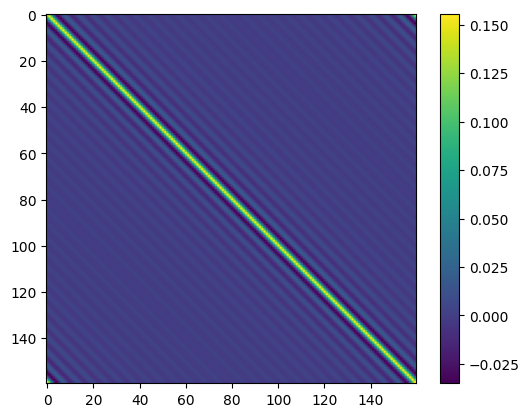

In [ ]:
from scipy.linalg import toeplitz
W_s = toeplitz(np.fft.fftshift(fitted_data))

plt.imshow(W_s)
plt.colorbar()
plt.show()
